In [1]:
import ee
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
from rasterio.plot import show

from src.data import mtbs
from src.visualization import ee_viz
from src.data import gedi_loader
from src.data import fire_perimeters
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB


import seaborn as sns
sns.set_theme()

import importlib
importlib.reload(mtbs)
importlib.reload(ee_viz)
importlib.reload(fire_perimeters)
importlib.reload(gedi_loader)

<module 'src.data.gedi_loader' from '/home/jk871/fire-regen/src/data/gedi_loader.py'>

### Get Creek Fire Info

Creek fire is the second largest Sierra fire from the years 2020/2021, and we have GEDI data for both before and after the fire.

In [2]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")

firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2020', '2021']).filter_within_geometry(sierras)

creek = sierra_firep.get_fire('CREEK')

In [3]:
raster_file_path = "/maps/fire-regen/data/rasters/CREEK/"

In [4]:
raster_db = FireRastersDB(raster_file_path, 'creek')

## Visualize Location and Perimeter

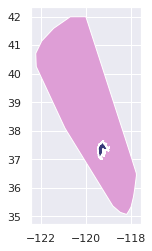

In [9]:
creek.overlay_fire_map(sierras)

In [10]:
creek.get().geometry.explore()

### Get fire GEDI shots and match them to NBR rasters

In [5]:
creek.load_gedi(load_buffer=True)

2023-05-06 11:15:10,585 INFO: Loading Level 4a GEDI shots for period 2019-2023 in this geometry [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:20]
2023-05-06 11:15:41,596 INFO: Number of GEDI shots found: 110015 [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:58]
2023-05-06 11:15:41,650 INFO: Loading Level 4a GEDI shots for period 2019-2023 in this geometry [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:20]
2023-05-06 11:16:34,665 INFO: Number of GEDI shots found: 162130 [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:58]


### Get CREEK severity rasters

In [106]:
def before_fire(shots):
    return shots[shots.absolute_time < creek.alarm_date]

def after_fire(shots):
    return shots[shots.absolute_time > creek.cont_date]

def filter_trees(shots):
    return shots[shots.pft_class == 1]

In [6]:
gedi_dnbr6 = match_gedi_to_raster(creek.gedi, raster_db.get('dnbr6'), 3, ['severity'])
gedi_dnbr = match_gedi_to_raster(creek.gedi, raster_db.get('dnbr'), 3, ['severity'])
gedi_rdnbr = match_gedi_to_raster(creek.gedi, raster_db.get('rdnbr'), 3, ['severity'])

In [7]:
gedi_buffer_dnbr6 = match_gedi_to_raster(creek.gedi_buffer, raster_db.get('dnbr6'), 3, ['severity'])
gedi_buffer_dnbr = match_gedi_to_raster(creek.gedi_buffer, raster_db.get('dnbr'), 3, ['severity'])
gedi_buffer_rdnbr = match_gedi_to_raster(creek.gedi_buffer, raster_db.get('rdnbr'), 3, ['severity'])

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

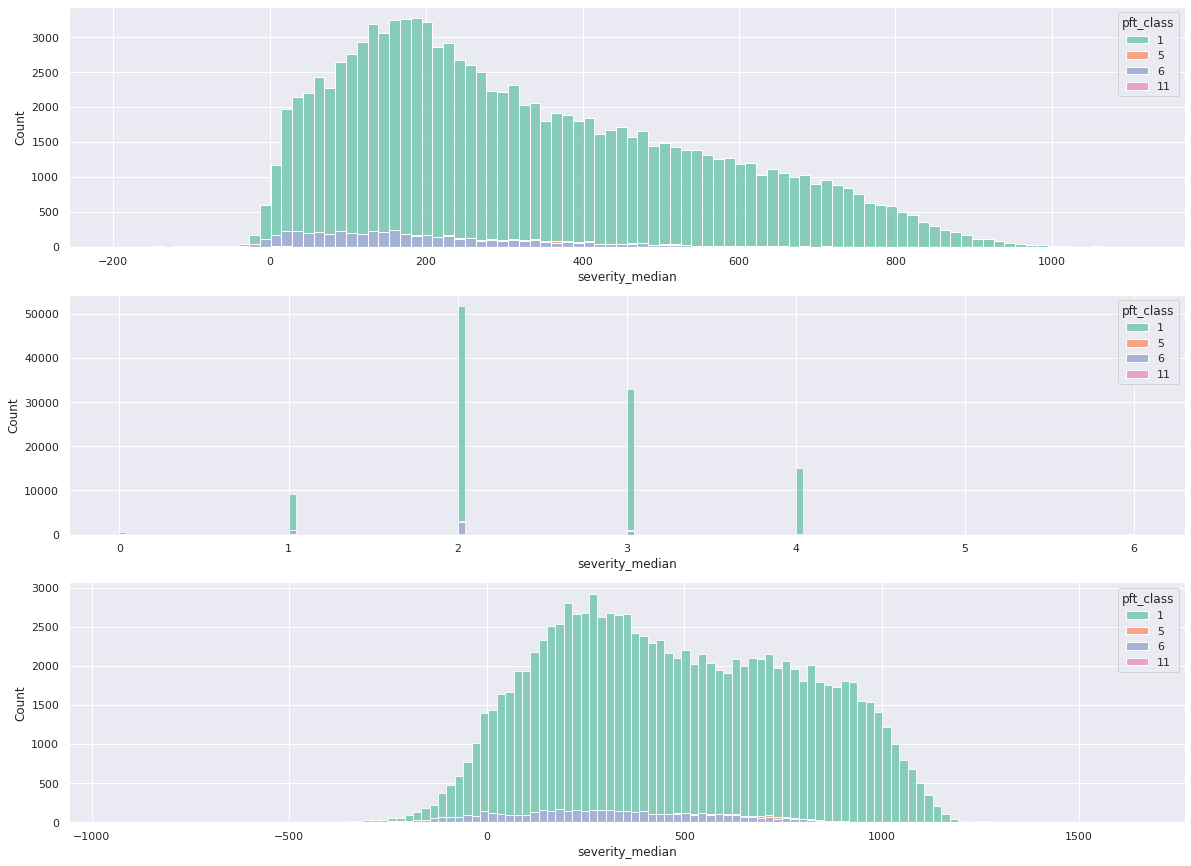

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(20,15))
sns.histplot(gedi_dnbr, x='severity_median', ax=ax[0], hue='pft_class', multiple='stack', palette='Set2')
sns.histplot(gedi_dnbr6, x='severity_median', ax=ax[1], hue='pft_class', multiple='stack', palette='Set2')
sns.histplot(gedi_rdnbr, x='severity_median', ax=ax[2], hue='pft_class', multiple='stack', palette='Set2')

(0.0, 1000.0)

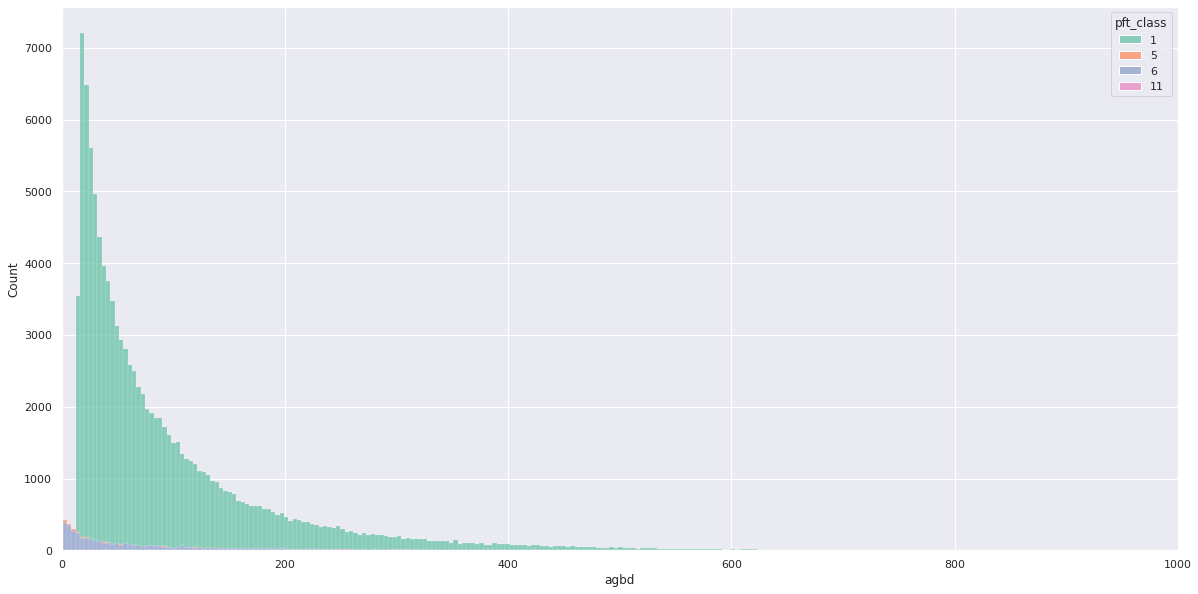

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
sns.histplot(gedi_dnbr, x='agbd', ax=ax, hue='pft_class', multiple='stack', palette='Set2')
ax.set_xlim((0, 1000))

In [70]:
def plot_severity(gdf, ax):
    gdf.plot(column='severity_median', ax=ax, legend=True, vmin=gdf.severity_median.quantile(0.05), vmax=gdf.severity_median.quantile(0.95), markersize=5, cmap='inferno_r')

def plot_agbd(gdf, ax, vmin=None, vmax=None):
    if vmin is None:
        vmin=gdf.agbd.quantile(0.05)
    if vmax is None:
        vmax=gdf.agbd.quantile(0.95)
    gdf.plot(column='agbd', ax=ax, legend=True, vmin=vmin, vmax=vmax, markersize=5, cmap='inferno_r')

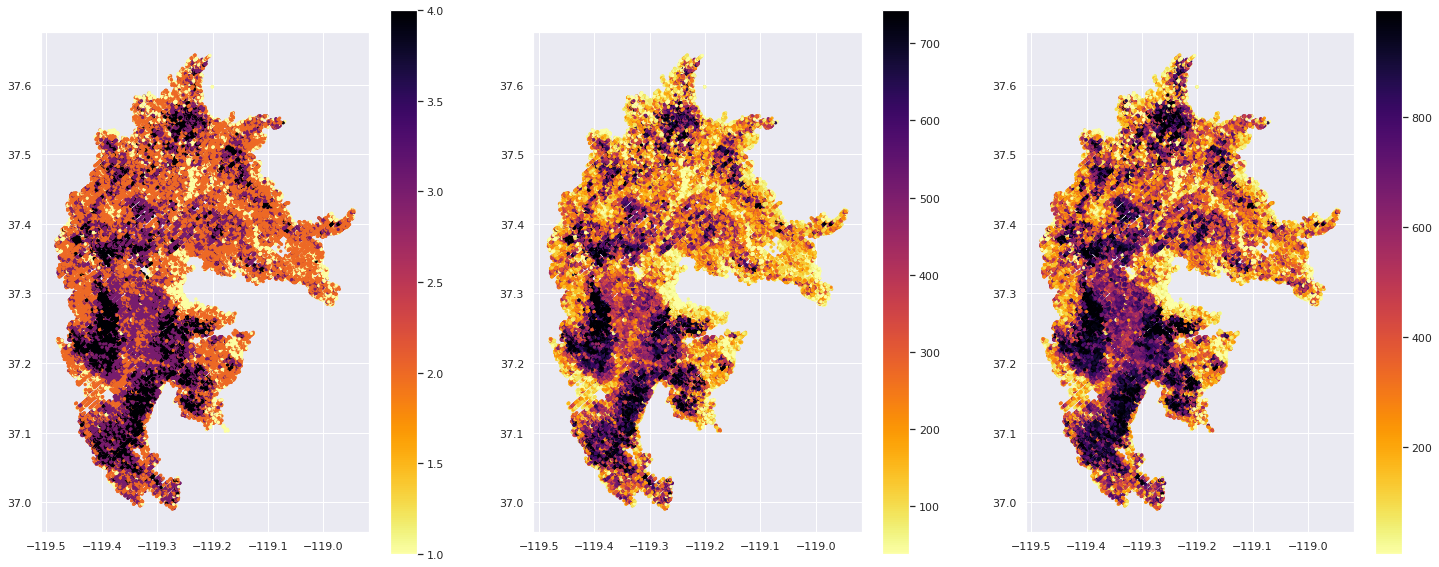

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(25,10))

plot_severity(gedi_dnbr6, ax[0])
plot_severity(gedi_dnbr, ax[1])
plot_severity(gedi_rdnbr, ax[2])

### Look at GEDI outliers - i.e. high values

In [91]:
gedi_dnbr[gedi_dnbr.agbd > 1000]

shot_number                     absolute_time  lon_lowestmode  \
12165    87140300200119742  2020-06-26 13:14:34.371534+01:00     -119.138257   
12571   222621100300286209  2022-11-17 09:32:45.694144+00:00     -119.181710   
26976   175890800200123658  2022-01-20 01:46:09.409000+00:00     -119.296725   
30647    21830200200229561  2019-05-02 11:57:51.793781+01:00     -119.329107   
43765   175891100200120018  2022-01-20 01:46:09.239588+00:00     -119.299293   
58641   138880600300528397  2021-05-26 08:14:45.707926+01:00     -119.117106   
73189    87140500200119808  2020-06-26 13:14:34.991334+01:00     -119.117775   
88382    87140300200119608  2020-06-26 13:14:33.264102+01:00     -119.203641   
105735  140101100300286998  2021-06-03 05:09:19.389124+01:00     -119.221711   
117790   87140800200123128  2020-06-26 13:14:32.970675+01:00     -119.245299   
151609  140710800300290278  2021-06-07 03:36:33.030732+01:00     -119.273817   
153501  174560100300289839  2022-01-11 12:15:09.706599+00:00     -119.309235   
196691  140100800300288201  2021-06-03 05:09:19.104016+01:00     -119.237471   
205229  175891100200120019  2022-01-20 01:46:09.247852+00:00     -119.298805   

        lat_lowestmode         agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
12165        37.541564  1050.158081     836.717712    1287.820190   4.381495   
12571        37.527129  2341.169189    1949.939087    2768.142822   6.465720   
26976        37.256257  1509.045654    1110.326050    1968.814087  11.271598   
30647        37.246484  1475.666504    1081.766968    1930.598877  11.268719   
43765        37.247141  1313.136475     943.685669    1743.478638  11.242555   
58641        37.543376  2191.876709    1702.715942    2742.720947  11.388708   
73189        37.547275  1047.258057     720.004944    1435.638794  11.286198   
88382        37.496661  1274.651001    1029.418091    1546.059692   4.734939   
105735       37.446379  1277.323608     913.308899    1702.249634  11.246241   
117790       37.444168  1100.885986     765.639343    1496.839966  11.208571   
151609       37.403068  1074.776489     857.814331    1316.173096   4.419974   
153501       37.336844  1000.508911     682.486877    1379.171265  11.196203   
196691       37.464271  2680.233887    2243.322266    3155.992920   7.027194   
205229       37.247479  1416.119141    1031.046387    1862.164673  11.257600   

       beam_type  sensitivity  pft_class                     geometry  \
12165   coverage     0.951421          6  POINT (-119.13826 37.54156)   
12571       full     0.975249          6  POINT (-119.18171 37.52713)   
26976       full     0.985050          1  POINT (-119.29673 37.25626)   
30647   coverage     0.967763          1  POINT (-119.32911 37.24648)   
43765       full     0.977031          1  POINT (-119.29929 37.24714)   
58641       full     0.964331          1  POINT (-119.11711 37.54338)   
73189       full     0.980088          1  POINT (-119.11778 37.54728)   
88382   coverage     0.955434          6  POINT (-119.20364 37.49666)   
105735      full     0.959217          1  POINT (-119.22171 37.44638)   
117790      full     0.962980          1  POINT (-119.24530 37.44417)   
151609      full     0.969577          6  POINT (-119.27382 37.40307)   
153501  coverage     0.957749          1  POINT (-119.30923 37.33684)   
196691      full     0.951657          6  POINT (-119.23747 37.46427)   
205229      full     0.981893          1  POINT (-119.29881 37.24748)   

                                         severity_3x3  severity_sample  \
12165     [107, 396, 407, 94, 396, 433, 68, 312, 429]              396   
12571      [0, 158, 313, 163, -13, 273, 166, 106, 98]              -13   
26976   [421, 323, 319, 421, 323, 375, 367, 383, 366]              323   
30647   [277, 197, 137, 168, 126, 206, 145, 229, 257]              126   
43765   [371, 349, 369, 440, 368, 447, 391, 399, 523]              368   
58641        [146, 214, 313, 76, 0, 313, 67, 10, 143]                0   

<AxesSubplot: >

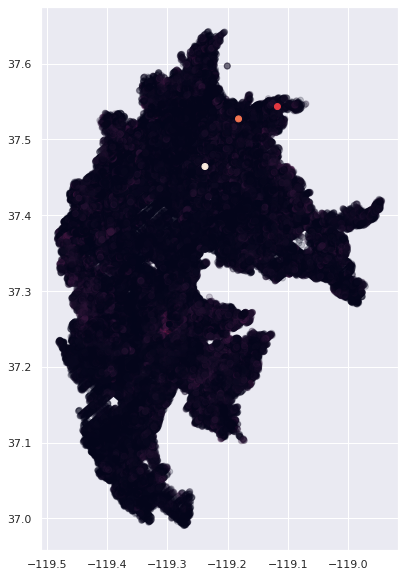

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

gedi_dnbr.plot(column='agbd', ax=ax, alpha=0.2)
gedi_dnbr[gedi_dnbr.agbd > 1500].plot(column='agbd', ax=ax)

### Look at GEDI before and after fire

In [30]:
print('AGBD before fire')
print(creek.get_gedi_before_fire().agbd.describe())

print('AGBD after fire')
print(creek.get_gedi_after_fire().agbd.describe())

AGBD before fire
count    42454.000000
mean       115.205988
std        106.792929
min          1.061925
25%         40.437689
50%         80.680099
75%        153.143761
max       1475.666504
Name: agbd, dtype: float64
AGBD after fire
count    67561.000000
mean        84.938165
std         93.600261
min          0.870713
25%         26.795208
50%         52.248116
75%        104.708260
max       2680.233887
Name: agbd, dtype: float64


(0.0, 700.0)

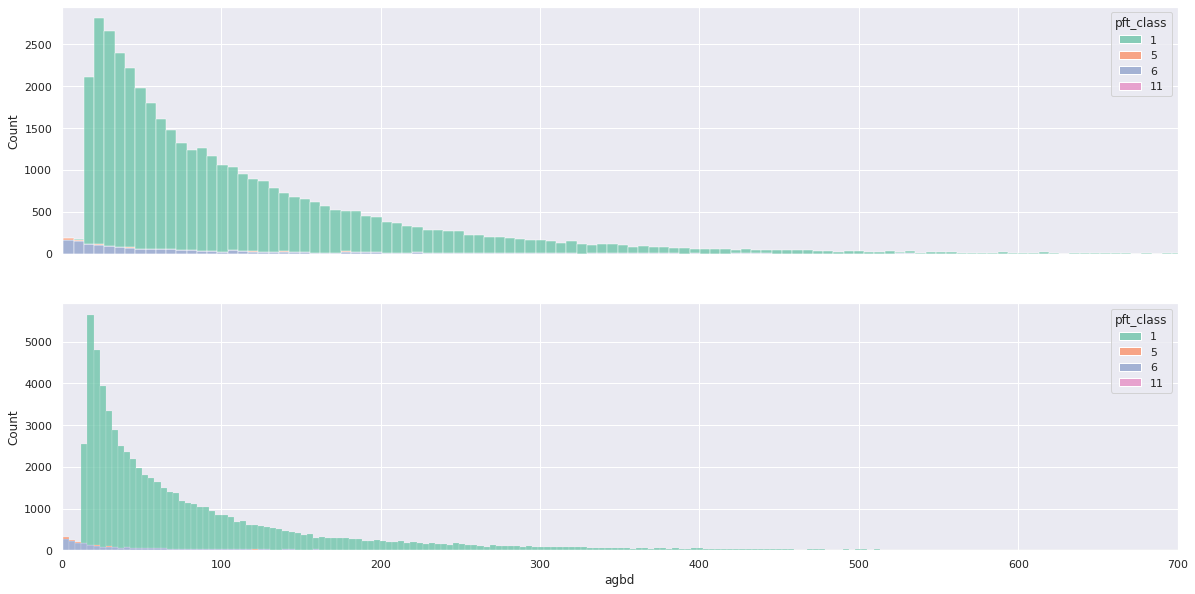

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_dnbr), x='agbd', ax=ax[0], hue='pft_class', multiple='stack', palette='Set2')
g = sns.histplot(after_fire(gedi_dnbr), x='agbd', ax=ax[1], hue='pft_class', multiple='stack', palette='Set2')
ax[1].set_xlim((0, 700))

(0.0, 700.0)

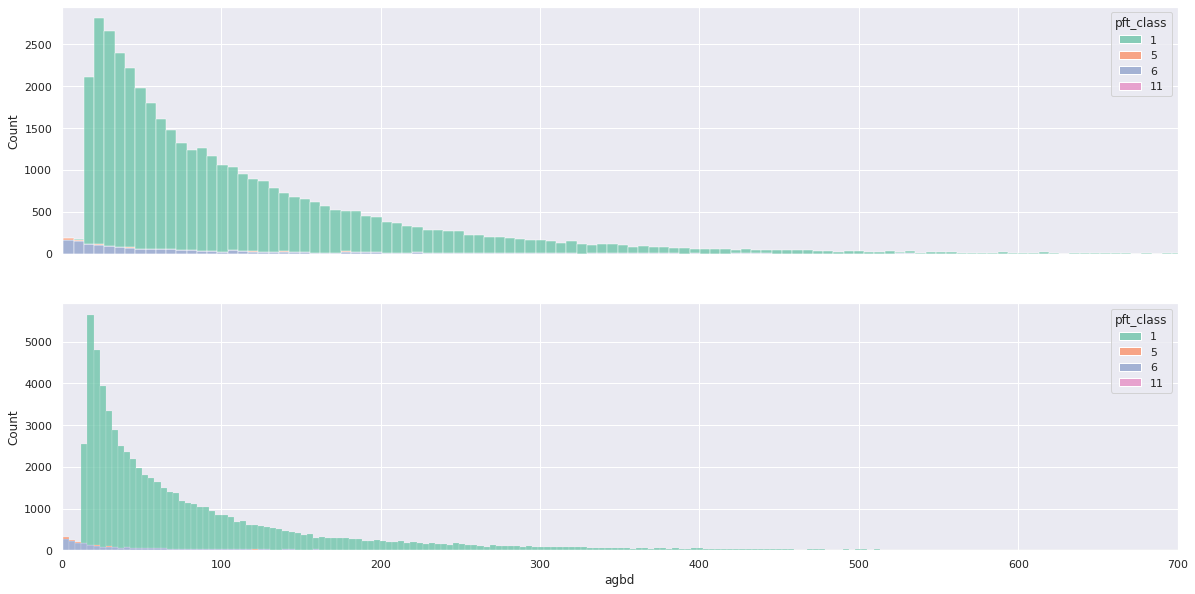

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_rdnbr), x='agbd', ax=ax[0], hue='pft_class', multiple='stack', palette='Set2')
g = sns.histplot(after_fire(gedi_rdnbr), x='agbd', ax=ax[1], hue='pft_class', multiple='stack', palette='Set2')
ax[1].set_xlim((0, 700))

(0.0, 700.0)

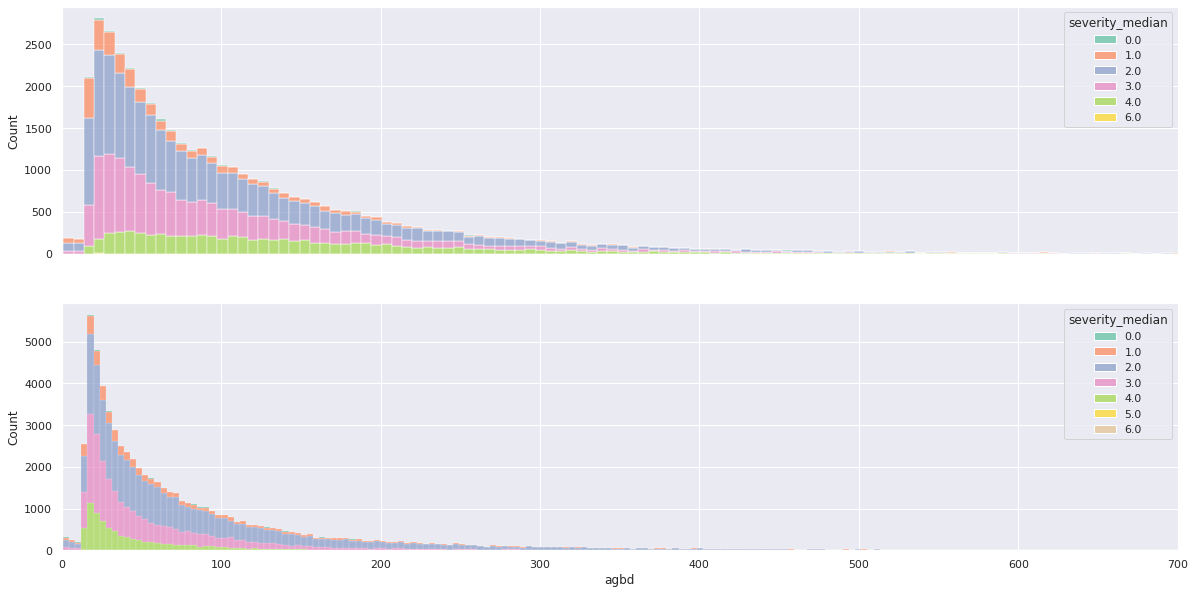

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_dnbr6), x='agbd', ax=ax[0], hue='severity_median', multiple='stack', palette='Set2')
g = sns.histplot(after_fire(gedi_dnbr6), x='agbd', ax=ax[1], hue='severity_median', multiple='stack', palette='Set2')
ax[1].set_xlim((0, 700))

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

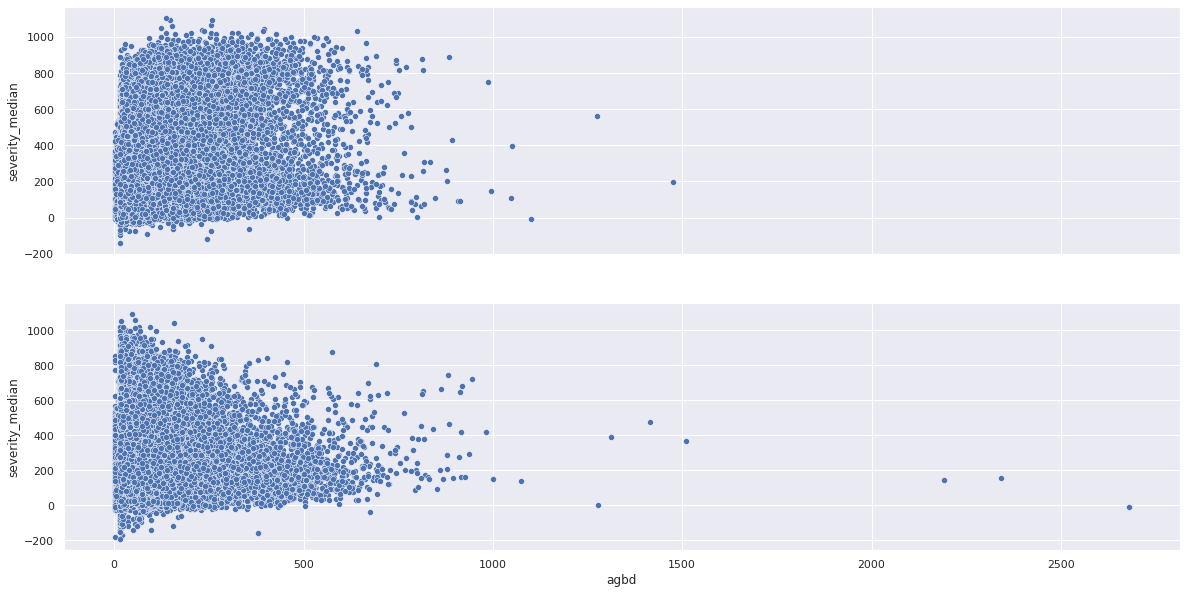

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(before_fire(gedi_dnbr), x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(after_fire(gedi_dnbr), x='agbd', y='severity_median', ax=ax[1])

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

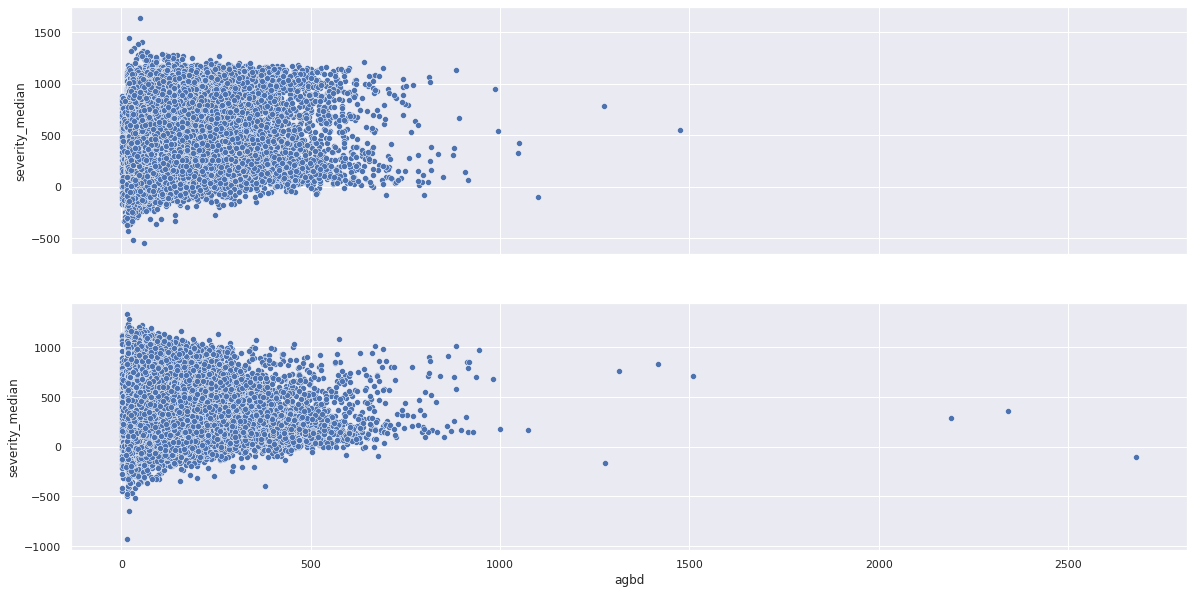

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(before_fire(gedi_rdnbr), x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(after_fire(gedi_rdnbr), x='agbd', y='severity_median', ax=ax[1])

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

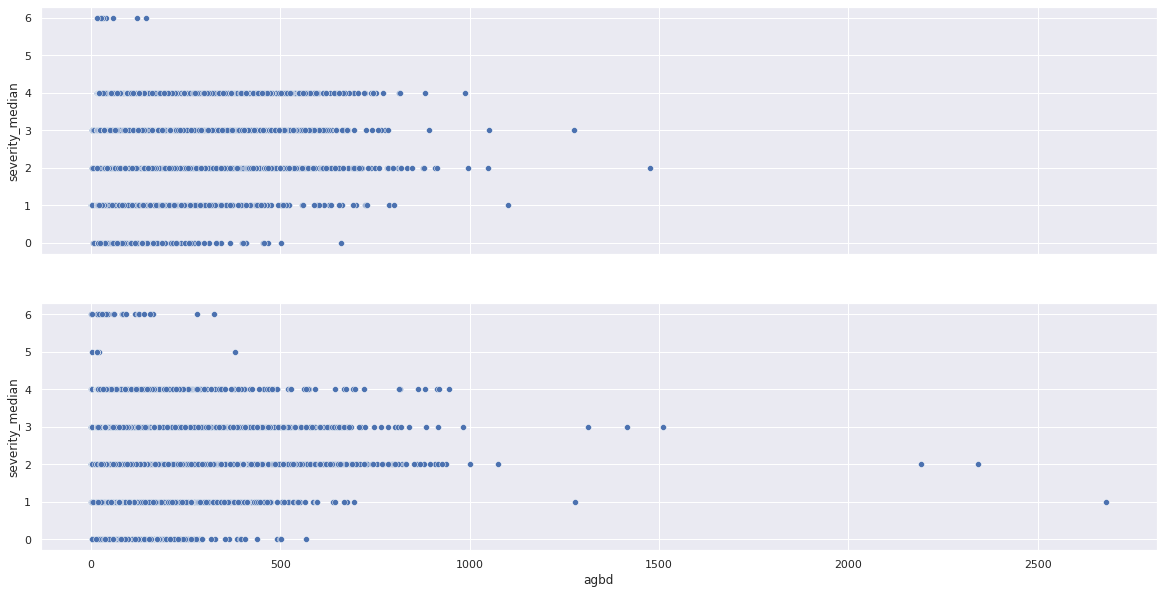

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(before_fire(gedi_dnbr6), x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(after_fire(gedi_dnbr6), x='agbd', y='severity_median', ax=ax[1])

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

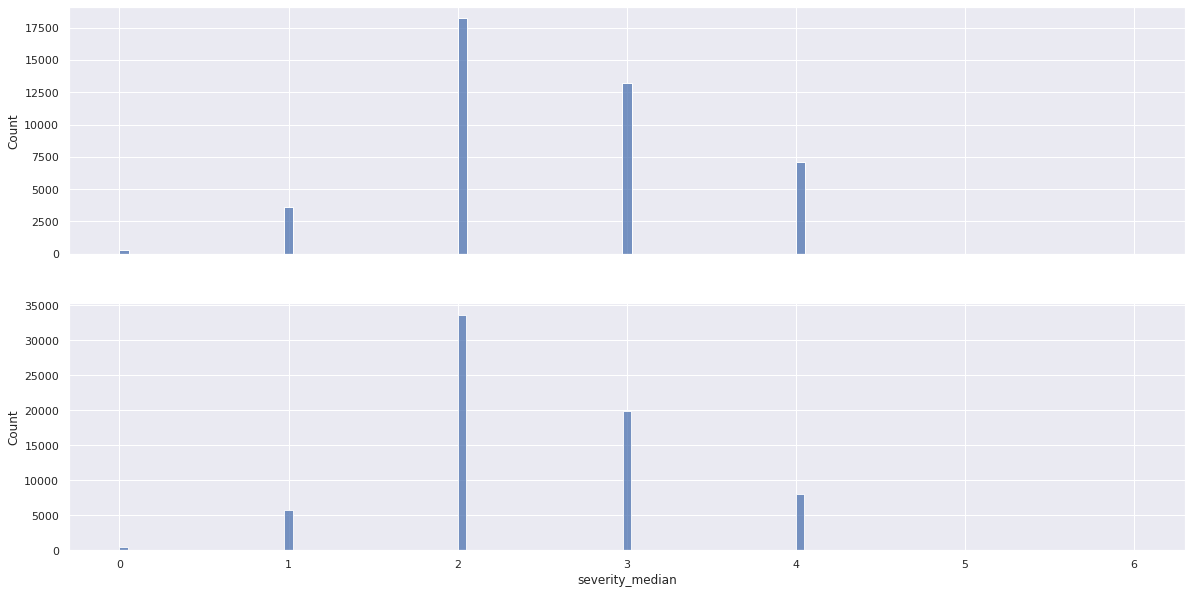

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_dnbr6), x='severity_median', ax=ax[0])
sns.histplot(after_fire(gedi_dnbr6), x='severity_median', ax=ax[1])

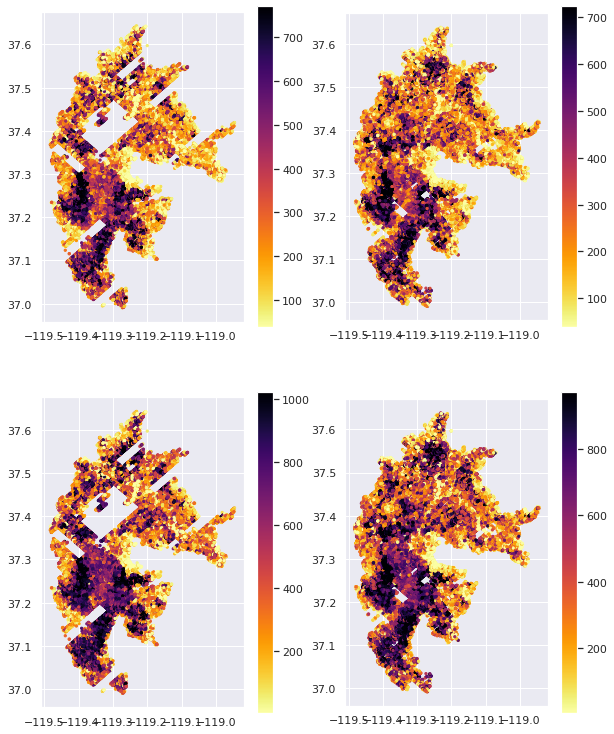

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(10,13))

plot_severity(before_fire(gedi_dnbr), ax=ax[0][0])
plot_severity(after_fire(gedi_dnbr), ax=ax[0][1])
plot_severity(before_fire(gedi_rdnbr), ax=ax[1][0])
plot_severity(after_fire(gedi_rdnbr), ax=ax[1][1])

### Look at unburned buffer zone GEDI before and after fire

In [73]:
unburned_before = before_fire(gedi_buffer_dnbr6)
unburned_after = after_fire(gedi_buffer_dnbr6)
print('AGBD before fire')
print(unburned_before.agbd.describe())

print('AGBD after fire')
print(unburned_after.agbd.describe())

AGBD before fire
count    57503.000000
mean       106.045784
std        103.552680
min          0.776436
25%         34.581120
50%         71.073746
75%        143.698608
max       1305.674316
Name: agbd, dtype: float64
AGBD after fire
count    104627.000000
mean         94.441961
std          97.104075
min           0.834731
25%          30.557607
50%          63.248981
75%         126.156799
max        2363.856201
Name: agbd, dtype: float64


In [74]:
unburned_before = before_fire(gedi_buffer_dnbr6[(gedi_buffer_dnbr6.severity_median == 0) & (gedi_buffer_dnbr6.severity_std == 0)])
unburned_after = after_fire(gedi_buffer_dnbr6[(gedi_buffer_dnbr6.severity_median == 0) & (gedi_buffer_dnbr6.severity_std == 0)])
print('AGBD before fire')
print(unburned_before.agbd.describe())

print('AGBD after fire')
print(unburned_after.agbd.describe())

AGBD before fire
count    56378.000000
mean       106.044228
std        103.697477
min          0.776436
25%         34.537249
50%         71.017010
75%        143.601967
max       1305.674316
Name: agbd, dtype: float64
AGBD after fire
count    102480.000000
mean         94.299110
std          97.140815
min           0.834731
25%          30.452015
50%          63.131622
75%         126.034212
max        2363.856201
Name: agbd, dtype: float64


In [75]:
print('AGBD before fire')
print(unburned_before[unburned_before.pft_class==1].agbd.describe())

print('AGBD after fire')
print(unburned_after[unburned_after.pft_class==1].agbd.describe())

AGBD before fire
count    44732.000000
mean       114.540393
std        104.273452
min         12.965409
25%         41.006650
50%         79.959671
75%        153.130283
max        986.387390
Name: agbd, dtype: float64
AGBD after fire
count    73939.000000
mean       103.313199
std         94.408173
min         11.694054
25%         39.555096
50%         73.456268
75%        135.480225
max       2363.856201
Name: agbd, dtype: float64


(0.0, 700.0)

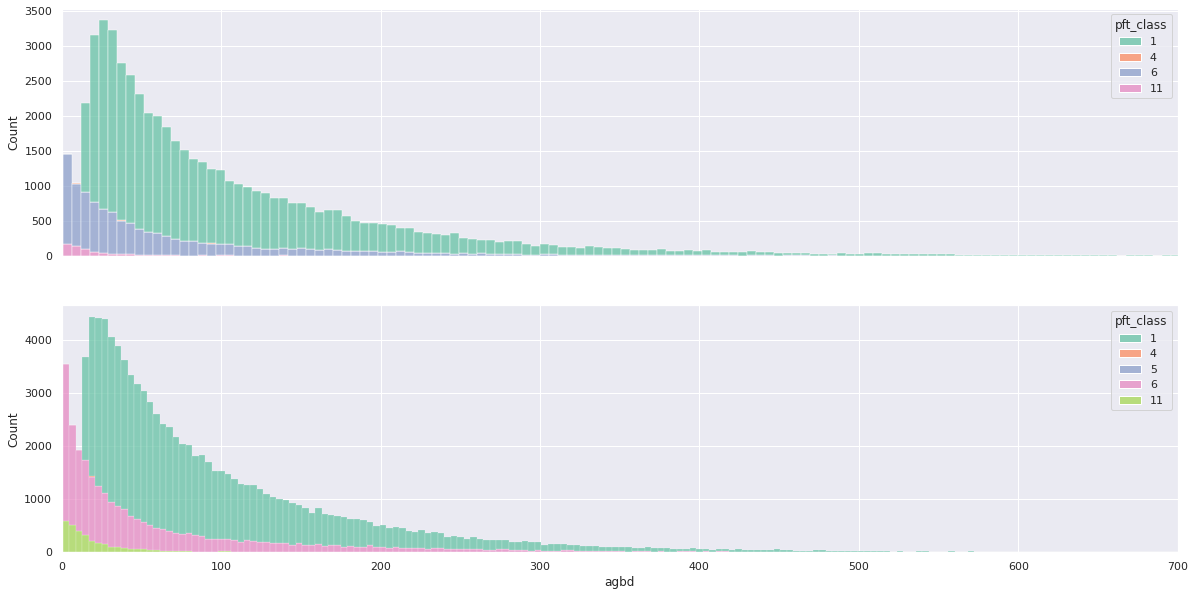

In [51]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_buffer_dnbr), x='agbd', ax=ax[0], hue='pft_class', multiple='stack', palette='Set2')
g = sns.histplot(after_fire(gedi_buffer_dnbr), x='agbd', ax=ax[1], hue='pft_class', multiple='stack', palette='Set2')
ax[1].set_xlim((0, 700))

<AxesSubplot: xlabel='agbd', ylabel='severity_median'>

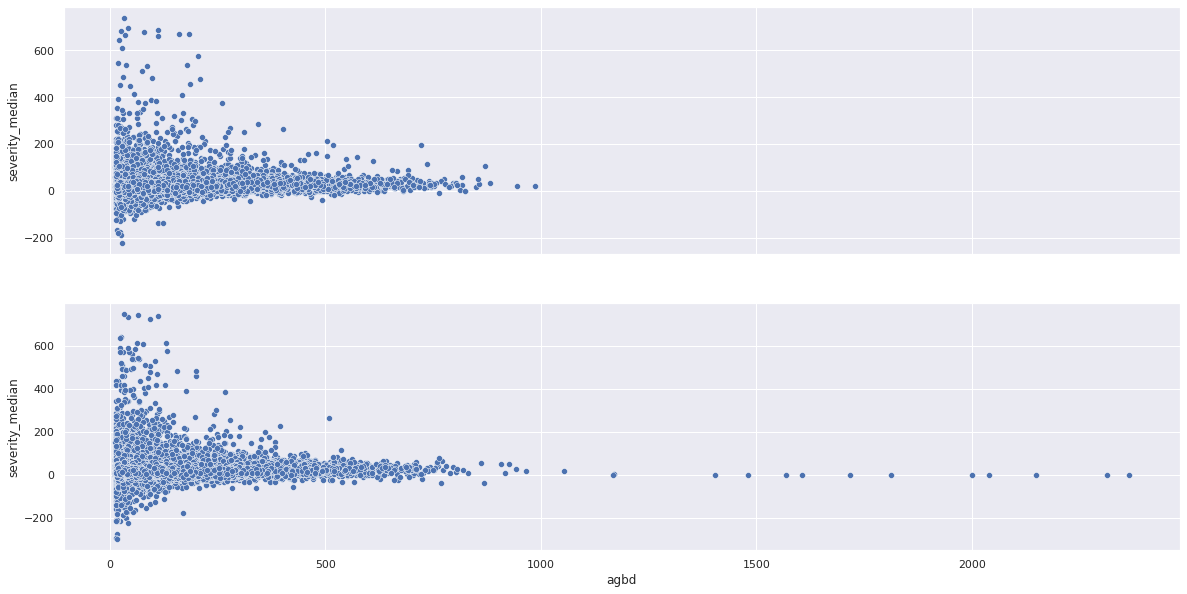

In [52]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.scatterplot(before_fire(gedi_buffer_dnbr)[before_fire(gedi_buffer_dnbr).pft_class==1], x='agbd', y='severity_median', ax=ax[0])
sns.scatterplot(after_fire(gedi_buffer_dnbr)[after_fire(gedi_buffer_dnbr).pft_class==1], x='agbd', y='severity_median', ax=ax[1])

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

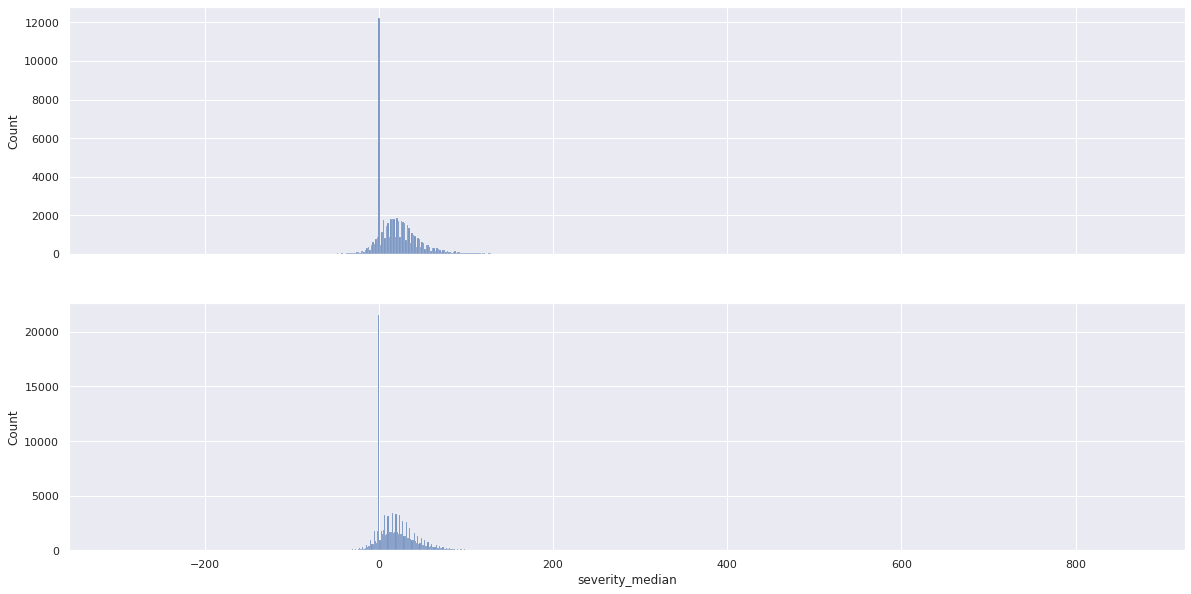

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_buffer_dnbr), x='severity_median', ax=ax[0])
sns.histplot(after_fire(gedi_buffer_dnbr), x='severity_median', ax=ax[1])

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

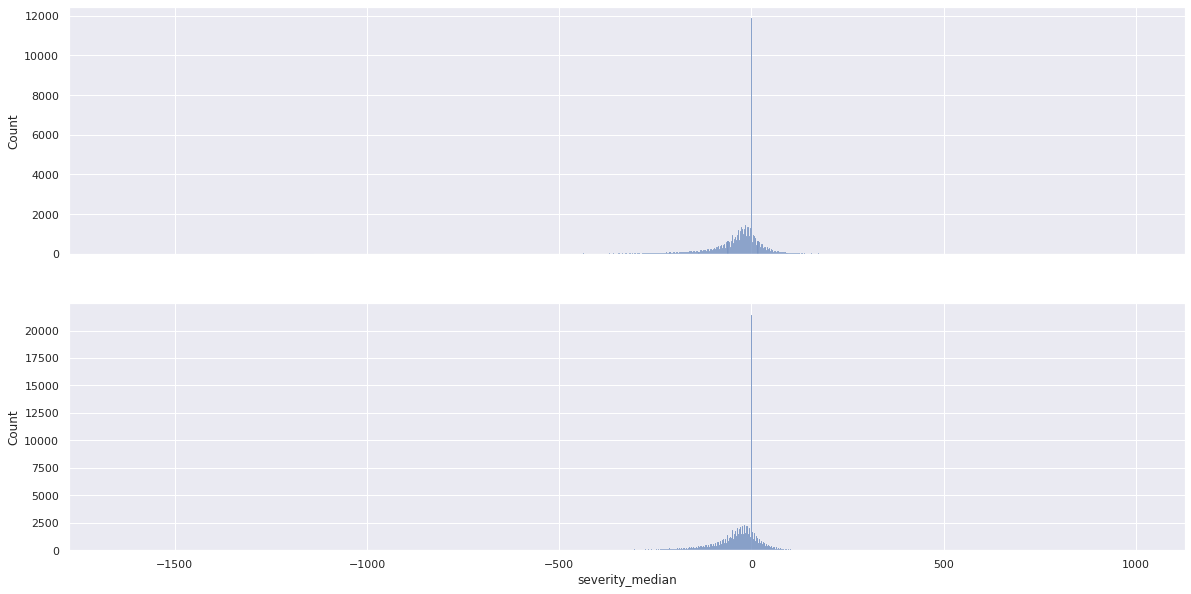

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_buffer_rdnbr), x='severity_median', ax=ax[0])
sns.histplot(after_fire(gedi_buffer_rdnbr), x='severity_median', ax=ax[1])

<AxesSubplot: xlabel='severity_median', ylabel='Count'>

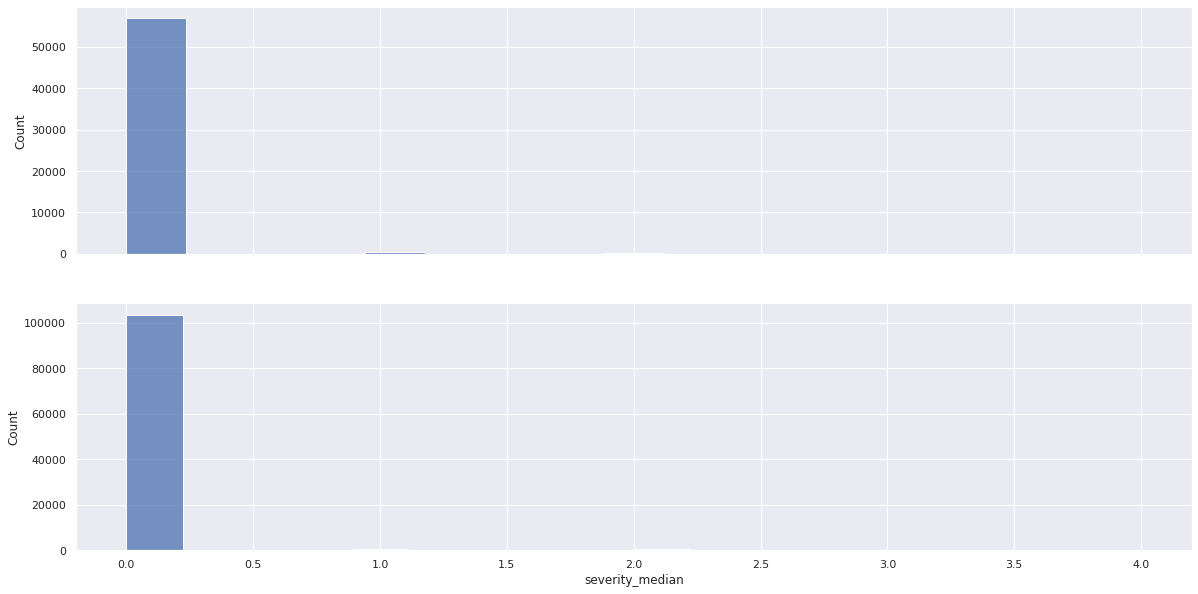

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.histplot(before_fire(gedi_buffer_dnbr6), x='severity_median', ax=ax[0])
sns.histplot(after_fire(gedi_buffer_dnbr6), x='severity_median', ax=ax[1])

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot: >

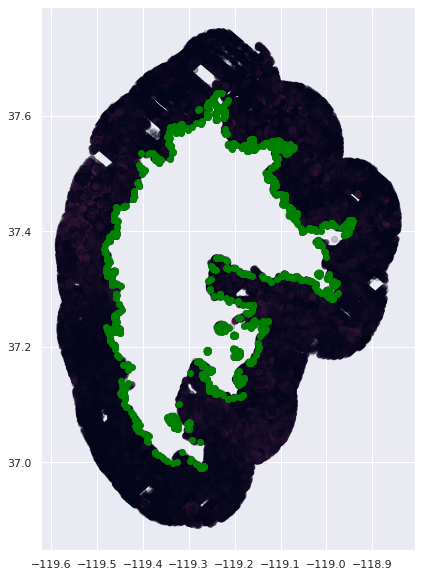

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

gedi_buffer_dnbr.plot(column='agbd', ax=ax, alpha=0.2)
gedi_buffer_dnbr6[gedi_buffer_dnbr6.severity_median != 0].plot(column='agbd', ax=ax, color='green')

Interesting, so all the shots in the outer region that have burn severity != 0 are around the fire perimeter. Which means when we're looking for counter-factual, we should focus on those pixels with burn severity of 0.

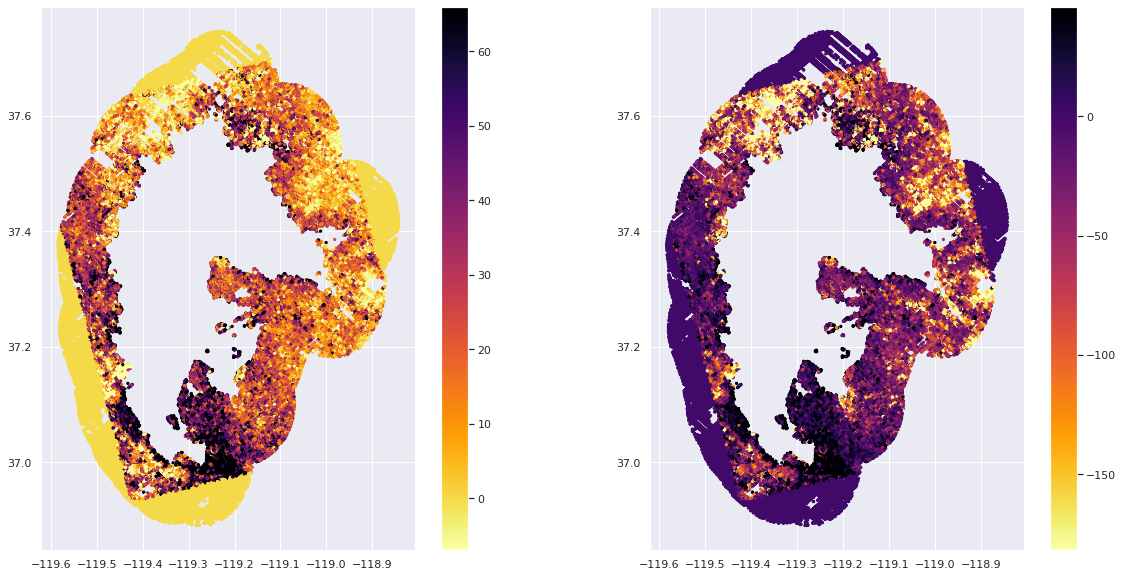

In [68]:

fig, ax = plt.subplots(1, 2, figsize=(20,10))

plot_severity(gedi_buffer_dnbr, ax=ax[0])
plot_severity(gedi_buffer_rdnbr, ax=ax[1])

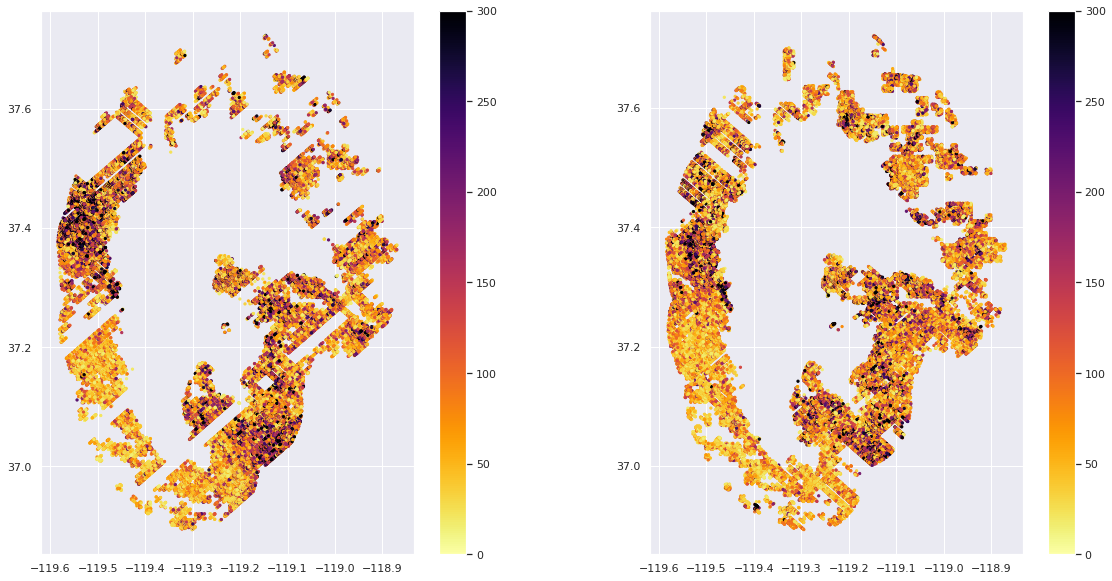

In [107]:

fig, ax = plt.subplots(1, 2, figsize=(20,10))

plot_agbd(unburned_before[unburned_before.pft_class==1], ax=ax[0], vmin=0, vmax=300)
plot_agbd(unburned_after[unburned_after.pft_class==1], ax=ax[1], vmin=0, vmax=300)

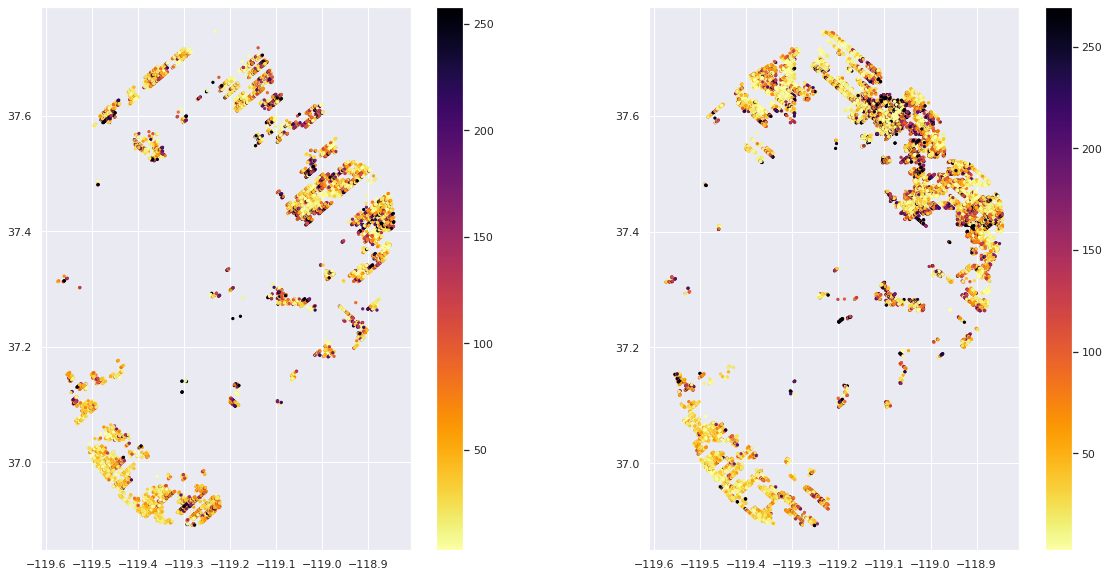

In [109]:

fig, ax = plt.subplots(1, 2, figsize=(20,10))

plot_agbd(unburned_before[unburned_before.pft_class==6], ax=ax[0])
plot_agbd(unburned_after[unburned_after.pft_class==6], ax=ax[1])

In [92]:
# Divide unburned after into two segments
unburned_after.absolute_time = pd.to_datetime(unburned_after.absolute_time, utc=True)

In [93]:
unburned_after_1 = unburned_after[unburned_after.absolute_time < '01-01-2022']

In [94]:
unburned_after_2 = unburned_after[unburned_after.absolute_time > '01-01-2022']

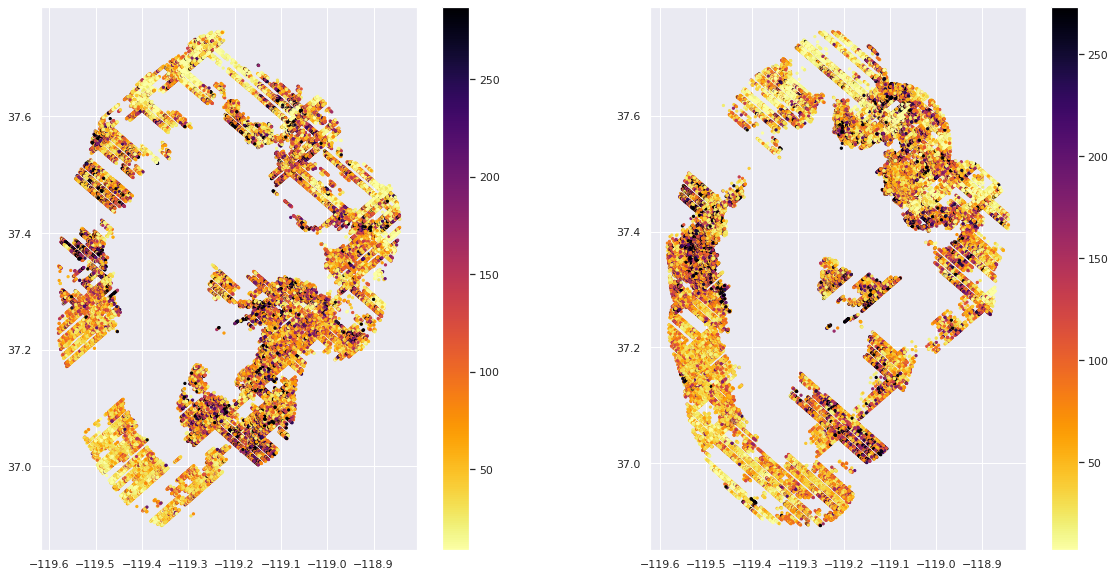

In [97]:

fig, ax = plt.subplots(1, 2, figsize=(20,10))

plot_agbd(unburned_after_1, ax=ax[0])
plot_agbd(unburned_after_2, ax=ax[1])

In [98]:
print('AGBD before fire')
print(unburned_after_1.agbd.describe())

print('AGBD after fire')
print(unburned_after_2.agbd.describe())

AGBD before fire
count    47360.000000
mean        98.988786
std         97.342301
min          0.834731
25%         33.005688
50%         68.399879
75%        133.249561
max       1651.483032
Name: agbd, dtype: float64
AGBD after fire
count    55120.000000
mean        90.269665
std         96.786913
min          0.858635
25%         28.709408
50%         58.616560
75%        119.831600
max       2363.856201
Name: agbd, dtype: float64


In [90]:
all_times = pd.to_datetime(creek.gedi.sort_values('absolute_time').absolute_time, utc=True)

In [88]:
all_times_before = pd.to_datetime(unburned_before.sort_values('absolute_time').absolute_time, utc=True)

In [96]:
unburned_after_2.absolute_time.dt.date.unique()

array([datetime.date(2022, 7, 22), datetime.date(2022, 1, 11),
       datetime.date(2022, 9, 9), datetime.date(2022, 3, 3),
       datetime.date(2022, 4, 10), datetime.date(2022, 11, 22),
       datetime.date(2022, 1, 24), datetime.date(2022, 9, 14),
       datetime.date(2022, 12, 18), datetime.date(2022, 10, 10),
       datetime.date(2022, 5, 10), datetime.date(2022, 1, 16),
       datetime.date(2022, 5, 19), datetime.date(2022, 2, 26),
       datetime.date(2022, 11, 18), datetime.date(2022, 11, 17),
       datetime.date(2022, 8, 18), datetime.date(2022, 6, 26),
       datetime.date(2022, 1, 20), datetime.date(2022, 5, 15),
       datetime.date(2022, 4, 13), datetime.date(2022, 4, 14),
       datetime.date(2022, 5, 14), datetime.date(2022, 2, 22),
       datetime.date(2022, 1, 7), datetime.date(2022, 12, 17),
       datetime.date(2022, 5, 18), datetime.date(2022, 1, 15),
       datetime.date(2022, 7, 26), datetime.date(2022, 8, 13)],
      dtype=object)

In [89]:
all_times_before.dt.date.unique()

array([datetime.date(2019, 4, 25), datetime.date(2019, 5, 2),
       datetime.date(2019, 5, 8), datetime.date(2019, 5, 9),
       datetime.date(2019, 6, 17), datetime.date(2019, 7, 13),
       datetime.date(2019, 7, 28), datetime.date(2019, 8, 7),
       datetime.date(2019, 9, 13), datetime.date(2019, 9, 18),
       datetime.date(2019, 10, 10), datetime.date(2019, 10, 14),
       datetime.date(2019, 11, 2), datetime.date(2019, 11, 6),
       datetime.date(2019, 12, 2), datetime.date(2020, 6, 26),
       datetime.date(2020, 6, 30), datetime.date(2020, 7, 4),
       datetime.date(2020, 7, 8), datetime.date(2020, 7, 12)],
      dtype=object)

In [100]:
gedi_dnbr.corr()

/tmp/ipykernel_4169458/608907356.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gedi_dnbr.corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000        0.012291        0.166844 -0.156687   
lon_lowestmode      0.012291        1.000000        0.264490  0.025284   
lat_lowestmode      0.166844        0.264490        1.000000  0.021801   
agbd               -0.156687        0.025284        0.021801  1.000000   
agbd_pi_lower      -0.162302        0.066518        0.022007  0.423876   
agbd_pi_upper      -0.166894        0.020692        0.013787  0.990183   
agbd_se             0.002270       -0.084964       -0.080353 -0.014346   
sensitivity        -0.211113       -0.047579       -0.121222  0.173772   
pft_class          -0.003409        0.087887        0.083490  0.026084   
severity_sample    -0.052717       -0.270873       -0.263678 -0.031167   
severity_mean      -0.051289       -0.291659       -0.280956 -0.035368   
severity_std       -0.005277       -0.021666        0.017548 -0.027104   
severity_median    -0.052281       -0.288592       -0.280773 -0.034098   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number          -0.162302      -0.166894  0.002270    -0.211113   
lon_lowestmode        0.066518       0.020692 -0.084964    -0.047579   
lat_lowestmode        0.022007       0.013787 -0.080353    -0.121222   
agbd                  0.423876       0.990183 -0.014346     0.173772   
agbd_pi_lower         1.000000       0.467366 -0.044537     0.173402   
agbd_pi_upper         0.467366       1.000000  0.092385     0.202819   
agbd_se              -0.044537       0.092385  1.000000     0.169438   
sensitivity           0.173402       0.202819  0.169438     1.000000   
pft_class             0.048778      -0.081188 -0.996222    -0.167523   
severity_sample      -0.055383      -0.021000  0.125734     0.076302   
severity_mean        -0.066626      -0.024844  0.136518     0.077087   
severity_std         -0.022245      -0.024895  0.036748    -0.020685   
severity_median      -0.064231      -0.023599  0.134873     0.077614   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number      -0.003409        -0.052717      -0.051289     -0.005277   
lon_lowestmode    0.087887        -0.270873      -0.291659     -0.021666   
lat_lowestmode    0.083490        -0.263678      -0.280956      0.017548   
agbd              0.026084        -0.031167      -0.035368     -0.027104   
agbd_pi_lower     0.048778        -0.055383      -0.066626     -0.022245   
agbd_pi_upper    -0.081188        -0.021000      -0.024844     -0.024895   
agbd_se          -0.996222         0.125734       0.136518      0.036748   
sensitivity      -0.167523         0.076302       0.077087     -0.020685   
pft_class         1.000000        -0.127086      -0.138150     -0.036471   
severity_sample  -0.127086         1.000000       0.958957      0.202306   
severity_mean    -0.138150         0.958957       1.000000      0.187976   
severity_std     -0.036471         0.202306       0.187976      1.000000   
severity_median  -0.136474         0.961977       0.991364      0.205151   

                 severity_median  
shot_number            -0.052281  
lon_lowestmode         -0.288592  
lat_lowestmode         -0.280773  
agbd                   -0.034098  
agbd_pi_lower          -0.064231  
agbd_pi_upper          -0.023599  
agbd_se                 0.134873  
sensitivity             0.077614  
pft_class              -0.136474  
severity_sample         0.961977  
severity_mean           0.991364  
severity_std            0.205151  
severity_median         1.000000

In [101]:
before_fire(gedi_dnbr).corr()

/tmp/ipykernel_4169458/795121377.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  before_fire(gedi_dnbr).corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000        0.161146       -0.152563 -0.016801   
lon_lowestmode      0.161146        1.000000        0.207529 -0.044781   
lat_lowestmode     -0.152563        0.207529        1.000000  0.038277   
agbd               -0.016801       -0.044781        0.038277  1.000000   
agbd_pi_lower       0.021204       -0.008114        0.029213  0.376057   
agbd_pi_upper      -0.012658       -0.048652        0.029890  0.991438   
agbd_se             0.025688       -0.039454       -0.087169  0.013330   
sensitivity         0.046230       -0.096967       -0.136018  0.170036   
pft_class          -0.024983        0.042197        0.090421 -0.001886   
severity_sample     0.042693       -0.271135       -0.271101  0.150144   
severity_mean       0.044140       -0.292461       -0.290334  0.148411   
severity_std       -0.007411       -0.008815        0.003328  0.019122   
severity_median     0.043805       -0.288547       -0.288838  0.148804   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number           0.021204      -0.012658  0.025688     0.046230   
lon_lowestmode       -0.008114      -0.048652 -0.039454    -0.096967   
lat_lowestmode        0.029213       0.029890 -0.087169    -0.136018   
agbd                  0.376057       0.991438  0.013330     0.170036   
agbd_pi_lower         1.000000       0.413195 -0.023617     0.172996   
agbd_pi_upper         0.413195       1.000000  0.115701     0.198664   
agbd_se              -0.023617       0.115701  1.000000     0.192395   
sensitivity           0.172996       0.198664  0.192395     1.000000   
pft_class             0.028077      -0.104669 -0.995487    -0.189441   
severity_sample       0.142316       0.172473  0.143882     0.161352   
severity_mean         0.135880       0.171560  0.155575     0.162464   
severity_std          0.032635       0.025935  0.051065     0.007975   
severity_median       0.137176       0.171833  0.153550     0.162600   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number      -0.024983         0.042693       0.044140     -0.007411   
lon_lowestmode    0.042197        -0.271135      -0.292461     -0.008815   
lat_lowestmode    0.090421        -0.271101      -0.290334      0.003328   
agbd             -0.001886         0.150144       0.148411      0.019122   
agbd_pi_lower     0.028077         0.142316       0.135880      0.032635   
agbd_pi_upper    -0.104669         0.172473       0.171560      0.025935   
agbd_se          -0.995487         0.143882       0.155575      0.051065   
sensitivity      -0.189441         0.161352       0.162464      0.007975   
pft_class         1.000000        -0.144337      -0.156360     -0.050731   
severity_sample  -0.144337         1.000000       0.962491      0.249487   
severity_mean    -0.156360         0.962491       1.000000      0.260510   
severity_std     -0.050731         0.249487       0.260510      1.000000   
severity_median  -0.154308         0.963708       0.993281      0.250872   

                 severity_median  
shot_number             0.043805  
lon_lowestmode         -0.288547  
lat_lowestmode         -0.288838  
agbd                    0.148804  
agbd_pi_lower           0.137176  
agbd_pi_upper           0.171833  
agbd_se                 0.153550  
sensitivity             0.162600  
pft_class              -0.154308  
severity_sample         0.963708  
severity_mean           0.993281  
severity_std            0.250872  
severity_median         1.000000

In [102]:
before_fire(gedi_rdnbr).corr()

/tmp/ipykernel_4169458/2486856634.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  before_fire(gedi_rdnbr).corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000        0.161146       -0.152563 -0.016801   
lon_lowestmode      0.161146        1.000000        0.207529 -0.044781   
lat_lowestmode     -0.152563        0.207529        1.000000  0.038277   
agbd               -0.016801       -0.044781        0.038277  1.000000   
agbd_pi_lower       0.021204       -0.008114        0.029213  0.376057   
agbd_pi_upper      -0.012658       -0.048652        0.029890  0.991438   
agbd_se             0.025688       -0.039454       -0.087169  0.013330   
sensitivity         0.046230       -0.096967       -0.136018  0.170036   
pft_class          -0.024983        0.042197        0.090421 -0.001886   
severity_sample     0.025323       -0.230823       -0.232454  0.051322   
severity_mean       0.026088       -0.255444       -0.253850  0.055576   
severity_std       -0.015776        0.129336        0.127534 -0.083679   
severity_median     0.026429       -0.253211       -0.253831  0.055584   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number           0.021204      -0.012658  0.025688     0.046230   
lon_lowestmode       -0.008114      -0.048652 -0.039454    -0.096967   
lat_lowestmode        0.029213       0.029890 -0.087169    -0.136018   
agbd                  0.376057       0.991438  0.013330     0.170036   
agbd_pi_lower         1.000000       0.413195 -0.023617     0.172996   
agbd_pi_upper         0.413195       1.000000  0.115701     0.198664   
agbd_se              -0.023617       0.115701  1.000000     0.192395   
sensitivity           0.172996       0.198664  0.192395     1.000000   
pft_class             0.028077      -0.104669 -0.995487    -0.189441   
severity_sample       0.078374       0.068180  0.119403     0.122645   
severity_mean         0.076466       0.074200  0.136006     0.126954   
severity_std         -0.088822      -0.095580 -0.073602    -0.098899   
severity_median       0.078227       0.074222  0.135073     0.129382   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number      -0.024983         0.025323       0.026088     -0.015776   
lon_lowestmode    0.042197        -0.230823      -0.255444      0.129336   
lat_lowestmode    0.090421        -0.232454      -0.253850      0.127534   
agbd             -0.001886         0.051322       0.055576     -0.083679   
agbd_pi_lower     0.028077         0.078374       0.076466     -0.088822   
agbd_pi_upper    -0.104669         0.068180       0.074200     -0.095580   
agbd_se          -0.995487         0.119403       0.136006     -0.073602   
sensitivity      -0.189441         0.122645       0.126954     -0.098899   
pft_class         1.000000        -0.121728      -0.139192      0.072276   
severity_sample  -0.121728         1.000000       0.937976     -0.069866   
severity_mean    -0.139192         0.937976       1.000000     -0.074799   
severity_std      0.072276        -0.069866      -0.074799      1.000000   
severity_median  -0.137931         0.936269       0.988763     -0.119765   

                 severity_median  
shot_number             0.026429  
lon_lowestmode         -0.253211  
lat_lowestmode         -0.253831  
agbd                    0.055584  
agbd_pi_lower           0.078227  
agbd_pi_upper           0.074222  
agbd_se                 0.135073  
sensitivity             0.129382  
pft_class              -0.137931  
severity_sample         0.936269  
severity_mean           0.988763  
severity_std           -0.119765  
severity_median         1.000000

In [104]:
after_fire(gedi_dnbr).corr()

/tmp/ipykernel_4169458/861096128.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  after_fire(gedi_dnbr).corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000       -0.085777        0.243320 -0.079059   
lon_lowestmode     -0.085777        1.000000        0.299502  0.077321   
lat_lowestmode      0.243320        0.299502        1.000000  0.046053   
agbd               -0.079059        0.077321        0.046053  1.000000   
agbd_pi_lower      -0.066615        0.106614        0.052886  0.439513   
agbd_pi_upper      -0.081812        0.072080        0.040711  0.988868   
agbd_se             0.015746       -0.111373       -0.076029 -0.035629   
sensitivity         0.064048       -0.018345       -0.065000  0.126590   
pft_class          -0.016659        0.114494        0.079372  0.047623   
severity_sample     0.044211       -0.271161       -0.246504 -0.193579   
severity_mean       0.046699       -0.291799       -0.262946 -0.199931   
severity_std        0.006891       -0.027425        0.026164 -0.054782   
severity_median     0.045351       -0.289295       -0.263530 -0.198419   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number          -0.066615      -0.081812  0.015746     0.064048   
lon_lowestmode        0.106614       0.072080 -0.111373    -0.018345   
lat_lowestmode        0.052886       0.040711 -0.076029    -0.065000   
agbd                  0.439513       0.988868 -0.035629     0.126590   
agbd_pi_lower         1.000000       0.487018 -0.057299     0.124159   
agbd_pi_upper         0.487018       1.000000  0.076931     0.154073   
agbd_se              -0.057299       0.076931  1.000000     0.163995   
sensitivity           0.124159       0.154073  0.163995     1.000000   
pft_class             0.061324      -0.065571 -0.996667    -0.162971   
severity_sample      -0.182988      -0.193030  0.113760    -0.002355   
severity_mean        -0.197369      -0.199379  0.123998    -0.001556   
severity_std         -0.044365      -0.054872  0.030558    -0.036204   
severity_median      -0.194697      -0.197852  0.122587    -0.001142   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number      -0.016659         0.044211       0.046699      0.006891   
lon_lowestmode    0.114494        -0.271161      -0.291799     -0.027425   
lat_lowestmode    0.079372        -0.246504      -0.262946      0.026164   
agbd              0.047623        -0.193579      -0.199931     -0.054782   
agbd_pi_lower     0.061324        -0.182988      -0.197369     -0.044365   
agbd_pi_upper    -0.065571        -0.193030      -0.199379     -0.054872   
agbd_se          -0.996667         0.113760       0.123998      0.030558   
sensitivity      -0.162971        -0.002355      -0.001556     -0.036204   
pft_class         1.000000        -0.115817      -0.126301     -0.030308   
severity_sample  -0.115817         1.000000       0.955912      0.183253   
severity_mean    -0.126301         0.955912       1.000000      0.155602   
severity_std     -0.030308         0.183253       0.155602      1.000000   
severity_median  -0.124859         0.960295       0.989849      0.186947   

                 severity_median  
shot_number             0.045351  
lon_lowestmode         -0.289295  
lat_lowestmode         -0.263530  
agbd                   -0.198419  
agbd_pi_lower          -0.194697  
agbd_pi_upper          -0.197852  
agbd_se                 0.122587  
sensitivity            -0.001142  
pft_class              -0.124859  
severity_sample         0.960295  
severity_mean           0.989849  
severity_std            0.186947  
severity_median         1.000000

In [105]:
after_fire(gedi_rdnbr).corr()

/tmp/ipykernel_4169458/1135705856.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  after_fire(gedi_rdnbr).corr()


shot_number  lon_lowestmode  lat_lowestmode      agbd  \
shot_number         1.000000       -0.085777        0.243320 -0.079059   
lon_lowestmode     -0.085777        1.000000        0.299502  0.077321   
lat_lowestmode      0.243320        0.299502        1.000000  0.046053   
agbd               -0.079059        0.077321        0.046053  1.000000   
agbd_pi_lower      -0.066615        0.106614        0.052886  0.439513   
agbd_pi_upper      -0.081812        0.072080        0.040711  0.988868   
agbd_se             0.015746       -0.111373       -0.076029 -0.035629   
sensitivity         0.064048       -0.018345       -0.065000  0.126590   
pft_class          -0.016659        0.114494        0.079372  0.047623   
severity_sample     0.051675       -0.241854       -0.197324 -0.244264   
severity_mean       0.054117       -0.268753       -0.218346 -0.257228   
severity_std       -0.004311        0.069401        0.109874 -0.054790   
severity_median     0.053456       -0.266987       -0.218957 -0.260135   

                 agbd_pi_lower  agbd_pi_upper   agbd_se  sensitivity  \
shot_number          -0.066615      -0.081812  0.015746     0.064048   
lon_lowestmode        0.106614       0.072080 -0.111373    -0.018345   
lat_lowestmode        0.052886       0.040711 -0.076029    -0.065000   
agbd                  0.439513       0.988868 -0.035629     0.126590   
agbd_pi_lower         1.000000       0.487018 -0.057299     0.124159   
agbd_pi_upper         0.487018       1.000000  0.076931     0.154073   
agbd_se              -0.057299       0.076931  1.000000     0.163995   
sensitivity           0.124159       0.154073  0.163995     1.000000   
pft_class             0.061324      -0.065571 -0.996667    -0.162971   
severity_sample      -0.227513      -0.249157  0.085505    -0.021699   
severity_mean        -0.248033      -0.262308  0.097039    -0.021355   
severity_std         -0.033937      -0.063641 -0.060785    -0.052587   
severity_median      -0.249222      -0.265422  0.096928    -0.020552   

                 pft_class  severity_sample  severity_mean  severity_std  \
shot_number      -0.016659         0.051675       0.054117     -0.004311   
lon_lowestmode    0.114494        -0.241854      -0.268753      0.069401   
lat_lowestmode    0.079372        -0.197324      -0.218346      0.109874   
agbd              0.047623        -0.244264      -0.257228     -0.054790   
agbd_pi_lower     0.061324        -0.227513      -0.248033     -0.033937   
agbd_pi_upper    -0.065571        -0.249157      -0.262308     -0.063641   
agbd_se          -0.996667         0.085505       0.097039     -0.060785   
sensitivity      -0.162971        -0.021699      -0.021355     -0.052587   
pft_class         1.000000        -0.089440      -0.101602      0.059970   
severity_sample  -0.089440         1.000000       0.928209     -0.029626   
severity_mean    -0.101602         0.928209       1.000000     -0.065327   
severity_std      0.059970        -0.029626      -0.065327      1.000000   
severity_median  -0.101349         0.926948       0.987409     -0.078334   

                 severity_median  
shot_number             0.053456  
lon_lowestmode         -0.266987  
lat_lowestmode         -0.218957  
agbd                   -0.260135  
agbd_pi_lower          -0.249222  
agbd_pi_upper          -0.265422  
agbd_se                 0.096928  
sensitivity            -0.020552  
pft_class              -0.101349  
severity_sample         0.926948  
severity_mean           0.987409  
severity_std           -0.078334  
severity_median         1.000000